In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_UNKNOWN

In [3]:
def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [12]:
cnn_base = VGG16(input_shape=(448,448,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False

x = cnn_base.get_layer('block5_pool').output
x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)
x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
x = Reshape((4,),name='localization_output')(x)

model = Model(inputs=cnn_base.input, outputs=x)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy',iou_metric])
initial_weights = model.get_weights()

In [10]:
#mod.save_weights("vgg16-landmarks-localization.hd5")
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

In [13]:

for i in range(5):
    print("Loading file")
    #model.save_weights('model.h5')
    with open('data-localize-landmarks'+str(i)+'.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    try:
        with open('landmarks_localization_vgg16_stage1'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    print("loaded")
    history = model.fit(x=np.array(all_images),y=np.array(all_bboxes),batch_size=20,epochs=10,
                           validation_data=(np.array(test_images),np.array(test_bboxes)))
    history_record.append(history)
    train_score = model.evaluate(x=np.array(all_images),y=np.array(all_bboxes),batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y=np.array(test_bboxes),batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = model.predict(x=np.array(all_images),batch_size=50)
    test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
    try:
        with open('landmarks_localization_vgg16_stage1'+str(i)'.hd5','wb') as f:
            pickle.dump(model.get_weights(),f)
    except Exception as ex:
        print("Could not write",ex)
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)

Loading file
loaded
Train on 906 samples, validate on 76 samples
Epoch 1/10
906/906 [==============================] - 63s 70ms/step - loss: 7572.7639 - acc: 0.7969 - iou_metric: 0.4096 - val_loss: 2995.8891 - val_acc: 0.9342 - val_iou_metric: 0.4248
Epoch 2/10
906/906 [==============================] - 49s 54ms/step - loss: 891.2123 - acc: 0.8731 - iou_metric: 0.6130 - val_loss: 702.9982 - val_acc: 0.9605 - val_iou_metric: 0.5572
Epoch 3/10
906/906 [==============================] - 49s 54ms/step - loss: 520.5683 - acc: 0.8874 - iou_metric: 0.6757 - val_loss: 681.8597 - val_acc: 0.9605 - val_iou_metric: 0.5126
Epoch 4/10
906/906 [==============================] - 49s 54ms/step - loss: 451.9557 - acc: 0.9139 - iou_metric: 0.6932 - val_loss: 586.3215 - val_acc: 0.9605 - val_iou_metric: 0.6346
Epoch 5/10
906/906 [==============================] - 49s 54ms/step - loss: 462.1848 - acc: 0.9117 - iou_metric: 0.6962 - val_loss: 746.7450 - val_acc: 0.9474 - val_iou_metric: 0.4923
Epoch 6/10
90

75/75 [==============================] - 10s 131ms/step
predicting
Test Score [559.4650268554688, 0.9200000166893005, 0.6104161739349365]
Loading file
loaded
Train on 909 samples, validate on 75 samples
Epoch 1/10
909/909 [==============================] - 52s 58ms/step - loss: 7812.5715 - acc: 0.7492 - iou_metric: 0.4213 - val_loss: 2760.8616 - val_acc: 0.9200 - val_iou_metric: 0.4096
Epoch 2/10
909/909 [==============================] - 49s 54ms/step - loss: 745.3435 - acc: 0.9032 - iou_metric: 0.6363 - val_loss: 521.8258 - val_acc: 0.9067 - val_iou_metric: 0.6357
Epoch 3/10
909/909 [==============================] - 49s 54ms/step - loss: 467.5136 - acc: 0.9120 - iou_metric: 0.6856 - val_loss: 493.4784 - val_acc: 0.9067 - val_iou_metric: 0.6813
Epoch 4/10
909/909 [==============================] - 49s 54ms/step - loss: 387.5143 - acc: 0.9109 - iou_metric: 0.7100 - val_loss: 424.2808 - val_acc: 0.7467 - val_iou_metric: 0.6777
Epoch 5/10
909/909 [==============================] - 49s 5

In [14]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
with open('vgg16-landmark-predictions-stage1.pckl','wb') as file:
    pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [20]:
pred_landmarks

array([ 90.97837, 215.40627, 325.78687, 296.00388], dtype=float32)

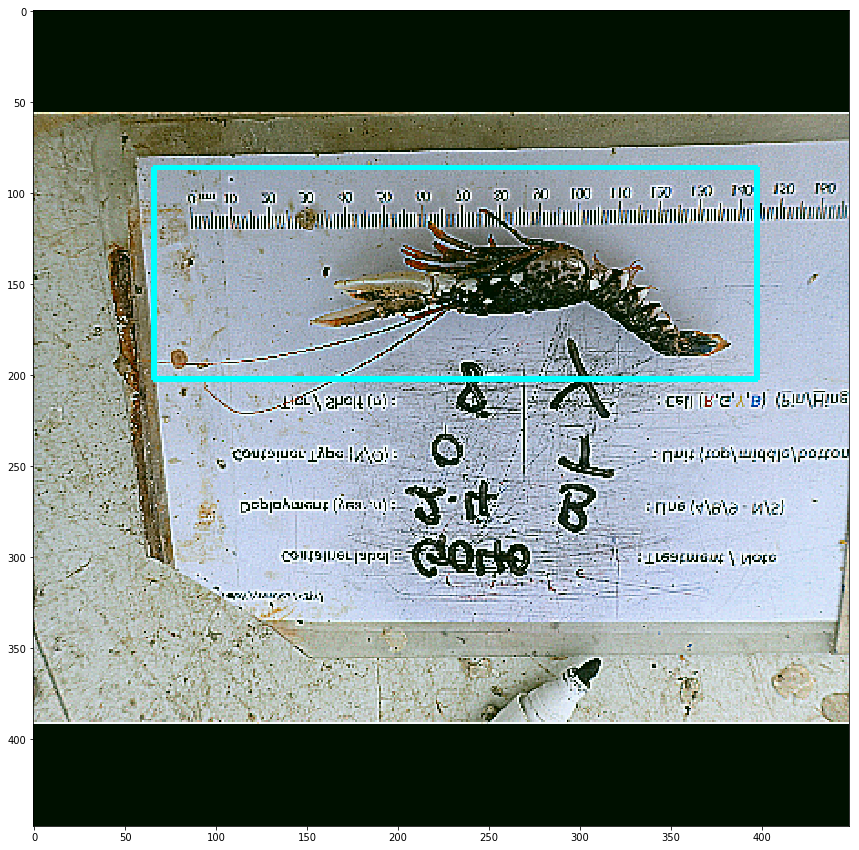

In [33]:
idx = 403
tuples = []
pred_landmarks = mod.predict(np.expand_dims(np.array(all_images[idx]),0))[0]
# for i in range(11):
#     tuples.append((pred_landmarks[i*2],pred_landmarks[i*2+1]))
# for i in range(11):
#     img = cv2.circle(test_images[idx],(int(tuples[i][0]),int(tuples[i][1])), 1, (0,0,255), -1)
pt1 = (int(pred_landmarks[0]),int(pred_landmarks[1]))
pt2 = (int(pred_landmarks[2]),int(pred_landmarks[3]))
img = cv2.rectangle(all_images[idx],pt1,pt2,(0,255,255),thickness=2)
pil_im = Image.fromarray(img)
plt.figure(figsize=(15,15))
plt.imshow(pil_im)

NameError: name 'history' is not defined

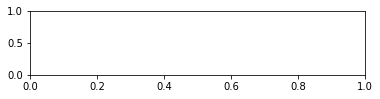

In [8]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [18]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
idx = 101

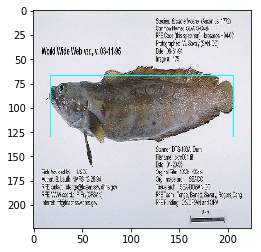

In [36]:
img = test_images[idx]
h,w,cx,cy,angle = testing_bboxes[idx]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

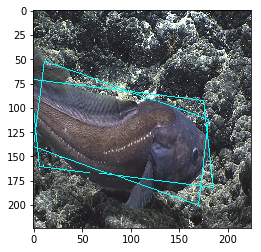

In [28]:
idx = 5
img = test_images[idx]
pts = np.array(test_bboxes[idx])
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

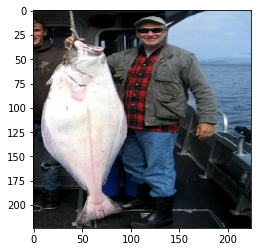

In [78]:
idx = 22
img = test_images[idx]
[[w,h,cx,cy,angle]] = mod.predict(np.expand_dims(test_images[idx],axis=0))[0]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [57]:
w,h,cx,cy,angle

(0.9990823, 0.00075547496, 4.3644923e-05, 0.00010419192, 1.4448374e-05)

In [53]:
mod.predict(np.expand_dims(test_images[6],axis=0))

[array([[149.92322 ,  82.941605, 126.17159 , 112.74586 ,  -0.889715]],
       dtype=float32),
 array([[1.1669288e-03, 9.3571018e-08, 7.4474216e-02, 3.6341050e-01,
         5.6094831e-01]], dtype=float32)]

In [79]:
test_scores

[]